## 1. Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import seaborn as sns
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
df_initial = pd.read_csv('CustomerSegmentation.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])


Dataframe dimensions: (541909, 8)


While looking at the number of null values in the dataframe, it is interesting to note that $\sim$25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So those records are deleted from the dataframe.

In [3]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'no. of null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
no. of null values,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('Duplicate entrees: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entrees: 5225


___
## 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

### 2.1 Customers and products

The number of users and products:

In [5]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be observed that the dataset has 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of $\sim$22'000.

Now the number of products purchased in every transaction will be calculated.

In [6]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

___
#### 2.1.1 Cancelled orders

The number of transactions corresponding to canceled orders:

In [7]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


It can be observed that the number of cancellations is quite large ($\sim$16% of the total number of transactions).

In [8]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


Creating a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were  performed before December 2010 (the point of entry of the database). Creating a census of the canceled orders and checking for the existence of counterparts:

In [9]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In the above cell, two cases are checked:
1. A cancel order that exists without counterpart
2. There's at least one counterpart with the exact same quantity

The index of the corresponding canceled order are respectively kept in the `doubtfull_entry` and `entry_to_remove` lists whose sizes are:

In [10]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Among these entries, the lines listed in the *doubtfull_entry* list correspond to the entries indicating a cancellation but for which there are no order beforehand. All of these entries are deleted, which count respectively for  $\sim$1.4% and 0.2% of the dataframe entries.

The number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [11]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


___
#### 2.1.2 Basket Price

Creating a new variable that indicates the total price of every purchase:

In [12]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. All the purchases made during a single order are collected to calculate the total order price:

In [13]:
#___________________________________________
# sum of purchases
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of important entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


Exploring purchase amount categories:

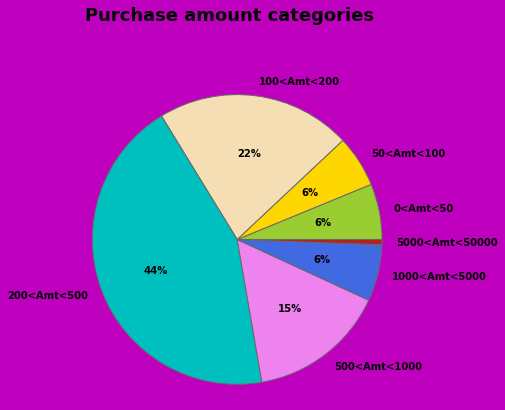

In [14]:
#____________________
# Purchase amount categories
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Pie chart of Purchase amount categories      
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(6, 6))
# plt.rcParams['axes.facecolor']='red'

colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<Amt<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.set_facecolor('m')

f.text(0.5, 1.01, "Purchase amount categories", ha='center', fontsize = 18, color = 'black');

It can be observed that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases give prizes in excess of $ 200.

____


## 3. Product categories

In the dataframe, products are uniquely identified through the **StockCode** variable. A shrort description of the products is given in the **Description** variable. In this section, the content of this **Description** variable is used to group the products into different categories.

___
### 3.1 Products Description

Extracting useful information (keywords) from the **Description** variable:

In [15]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, the root of the word is extracted. Then the set of names associated with this particular root is aggregated
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [16]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, the function defined above is used to analyze the description of the various products:

In [17]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1483


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

Converting the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [18]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Creating a representation of the most common keywords:

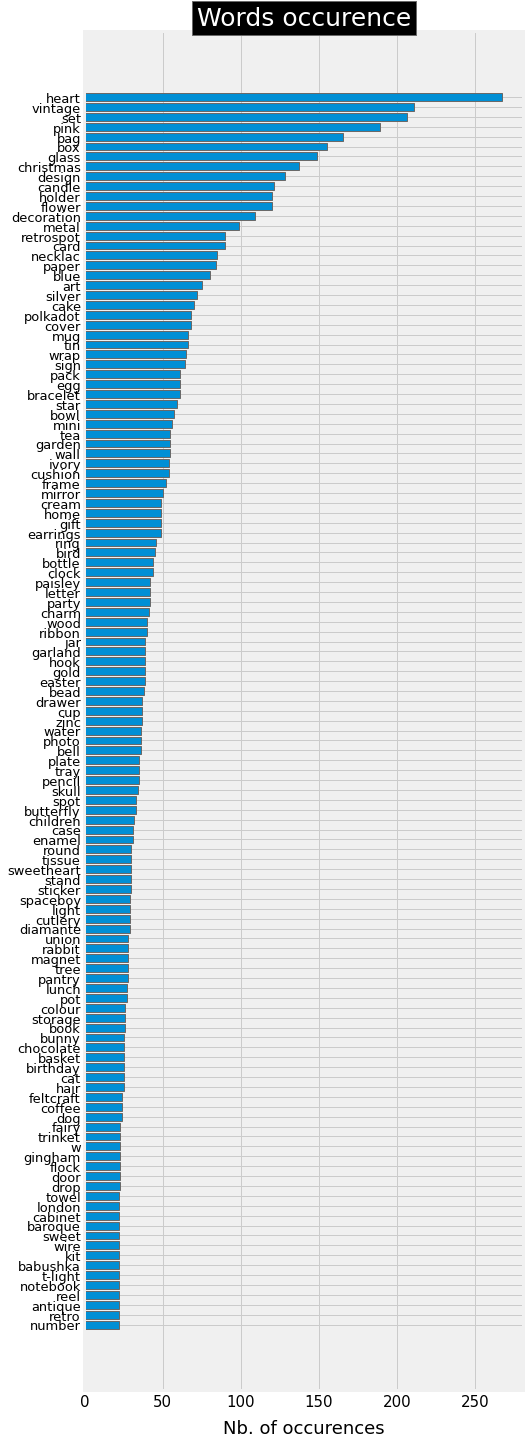

In [19]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories 

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, it can be observed that some names are useless. Others are do not carry information, like colors. Therefore, those words are discarded from the analysis that follows. Only the words that appear more than 13 times are considered in the further analysis.

In [20]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('important keywords:', len(list_products))

important keywords: 193


____
#### 3.2.1 Data encoding

Creatin groups of product using the keywords based on the one-hot-encoding principle

In [21]:
product_list = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), product_list))

In [22]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(product_list):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, the number of products in the different groups are checked:

In [23]:
print("{:<8} {:<20} \n".format('range', 'no. of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    no. of products      
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


____
#### 3.2.2 Creating clusters of products

In this section, the products will be grouped into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, the [kmodes](https://pypi.python.org/pypi/kmodes/) package needs to be used which is not available. Hence, **kmeans** method is used even though this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, the silhouette score will be used:

In [24]:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14740815062347604
For n_clusters = 6 The average silhouette_score is : 0.14473539992077658
For n_clusters = 7 The average silhouette_score is : 0.1496577731781852
For n_clusters = 8 The average silhouette_score is : 0.15342109568144105
For n_clusters = 9 The average silhouette_score is : 0.1530888194931896


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (slightly lower scores for the first cluster). On the other hand, it can be observed that beyond 5 clusters, some clusters contained very few elements. Therefore, to separate the dataset into different groups, 5 clusters will be chosed. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [25]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


___
#### 3.2.3  Characterizing the content of clusters

Calculating the number of elements in every class:

In [26]:
pd.Series(clusters).value_counts()

0    1009
4     964
3     673
2     626
1     606
dtype: int64

#### 3.2.4 Formatting data

Creating the categorical variable **categ_product** to indicate the cluster of each product :

In [27]:
corresp = dict()
for key, val in zip (product_list, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 3.2.5 Grouping products

Creating the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [28]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.0,0.00,0.0,15.3,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.0


Collecting the information related to a particular order and aggregating them in a single entry.

In [29]:
# Total purchase price
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
temp.head()

,CustomerID,InvoiceNo,TotalPrice
0,12346,541431,0.00
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52


In [30]:
# product category based on the percentage of the order price
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col] 

In [31]:
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,293.35,124.44,83.40,23.40,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,130.5,169.20,38.25,53.10,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,115.00,38.25,71.10,81.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,74.4,168.76,19.90,78.06,41.40,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,109.7,158.16,136.05,119.70,61.30,2011-08-02 08:48:00.000000000


____
## 4. Consumer Order Combinations

Grouping together the different entries that correspond to the same user.

In [32]:
#________________________________________________________________
# number of visits and stats on the basket amount / user
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,29.540371,12.041531,20.805104,11.237123
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,0.000000,38.016069
2,12349,1,1757.55,1757.55,1757.550000,1757.55,26.506216,10.713778,46.021450,12.245455,4.513101
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,0.000000,11.961722,27.900718,11.692584
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,14.601523,64.322571,4.071325,1.299404


Creating additional variables that give the number of days elapsed since the first purchase (**FirstPurchase**) and the number of days since the last purchase (**LastPurchase**):

In [33]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,29.540371,12.041531,20.805104,11.237123,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,0.000000,38.016069,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,26.506216,10.713778,46.021450,12.245455,4.513101,18,18
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,0.000000,11.961722,27.900718,11.692584,310,310
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,14.601523,64.322571,4.071325,1.299404,36,296


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. 

In [34]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("no. of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

no. of customers with a single purchase: 1489/4327  (34.41%)


Selecting a subset of variables:

In [35]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

## 5. Repeat Buyer feature engineering

In [36]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,29.540371,12.041531,20.805104,11.237123,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,0.000000,38.016069,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,26.506216,10.713778,46.021450,12.245455,4.513101,18,18
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,0.000000,11.961722,27.900718,11.692584,310,310
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,14.601523,64.322571,4.071325,1.299404,36,296


In [37]:
selected_customers.shape

(4327, 13)

In [38]:
n1 = selected_customers[selected_customers['count'] == 1].shape[0]
n1

1489

In [39]:
selected_customers['repeat_buyer'] = 1
selected_customers.loc[selected_customers['count'] == 1 , 'repeat_buyer'] = 0
selected_customers['repeat_buyer'].value_counts()

1    2838
0    1489
Name: repeat_buyer, dtype: int64

In [40]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,repeat_buyer
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,29.540371,12.041531,20.805104,11.237123,2,367,1
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,0.000000,38.016069,75,358,1
2,12349,1,1757.55,1757.55,1757.550000,1757.55,26.506216,10.713778,46.021450,12.245455,4.513101,18,18,0
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,0.000000,11.961722,27.900718,11.692584,310,310,0
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,14.601523,64.322571,4.071325,1.299404,36,296,1


In [41]:
selected_customers['shopping_frequency'] = \
    (selected_customers['FirstPurchase']-selected_customers['LastPurchase'])/selected_customers['count']

In [42]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,repeat_buyer,shopping_frequency
0,12347,7,224.82,1294.32,615.714286,4310.00,26.375870,29.540371,12.041531,20.805104,11.237123,2,367,1,52.142857
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,20.030714,0.000000,38.016069,75,358,1,70.750000
2,12349,1,1757.55,1757.55,1757.550000,1757.55,26.506216,10.713778,46.021450,12.245455,4.513101,18,18,0,0.000000
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,0.000000,11.961722,27.900718,11.692584,310,310,0,0.000000
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,14.601523,64.322571,4.071325,1.299404,36,296,1,37.142857


### 5.1 Repeat Buyer EDA

In [43]:
def plotting(column):
    if selected_customers[column].dtype != 'float64':
        f, axes = plt.subplots(1,1,figsize=(15,5))
        sns.countplot(x=column, hue='repeat_buyer', data = selected_customers)
        plt.xticks(rotation=90)
        plt.suptitle(column,fontsize=20)
        plt.show()
    else:
        g = sns.FacetGrid(selected_customers, row="repeat_buyer", margin_titles=True, aspect=4, height=3)
        g.map(plt.hist,column,bins=50)
        plt.show()
    plt.show()

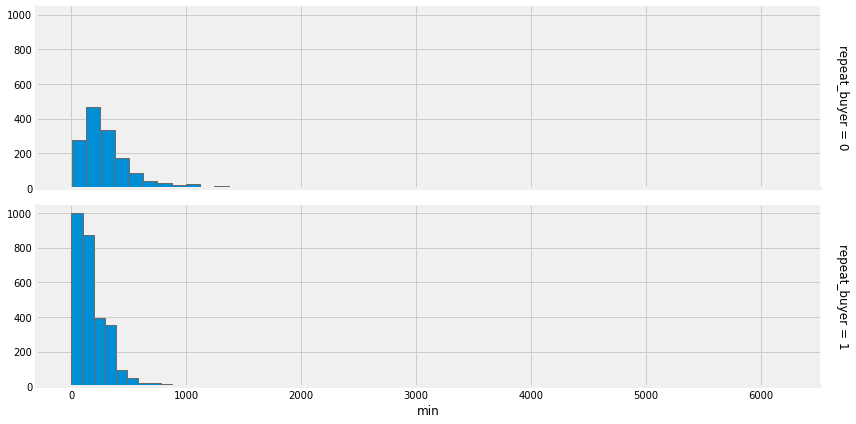

In [44]:
plotting("min")

In [45]:
def col_vs_repeat(col):
    df_new = selected_customers.copy()
    df_new[col] = pd.qcut(df_new[col], 7)
    res = df_new.groupby([col, 'repeat_buyer']).count()
    res = res.reset_index()

    sns.set(style="white")
    g = sns.catplot(x=col,
                    y= 'CustomerID',
                    hue='repeat_buyer',
                    data=res,
                    kind='bar',
                    ci=None,
                       )
    g.set_axis_labels(col, "repeat_buyer")
    plt.xticks(rotation=45)
    plt.show()

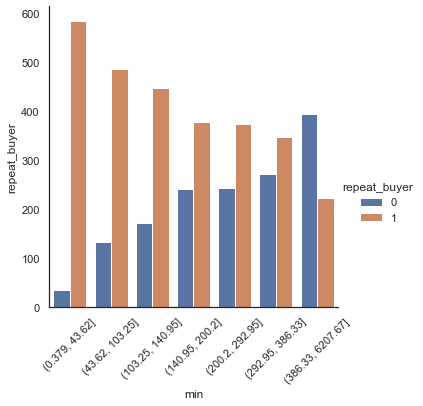

In [46]:
col_vs_repeat('min')

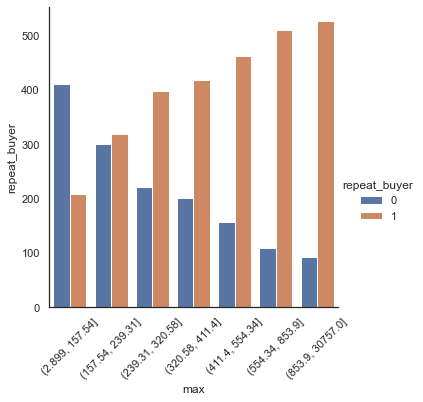

In [47]:
col_vs_repeat('max')

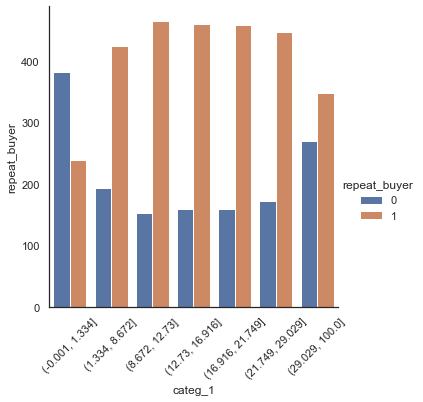

In [48]:
col_vs_repeat('categ_1')

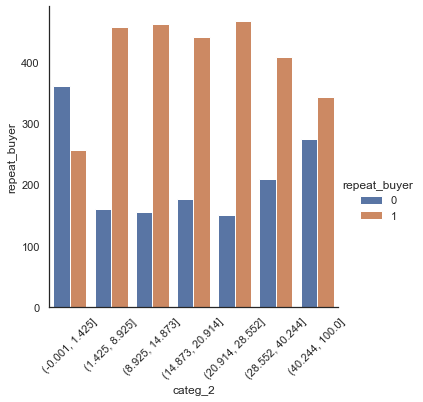

In [49]:
col_vs_repeat('categ_2')

## 6. Repeat Buyer Classification

### 6.1 Splitting the Data

In [50]:
X = selected_customers[['min', 'max', 'mean', 'categ_0',
       'categ_1', 'categ_2', 'categ_3', 'categ_4']]
y = selected_customers['repeat_buyer']

### Train test split

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [52]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state = 0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

### 6.2 KNN CLASSIFIER

In [53]:
from sklearn.neighbors import KNeighborsClassifier

train_score_array = []
test_score_array = []

for k in range(1,20):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    train_score_array.append(knn.score(X_train, y_train))
    test_score_array.append(knn.score(X_test, y_test))

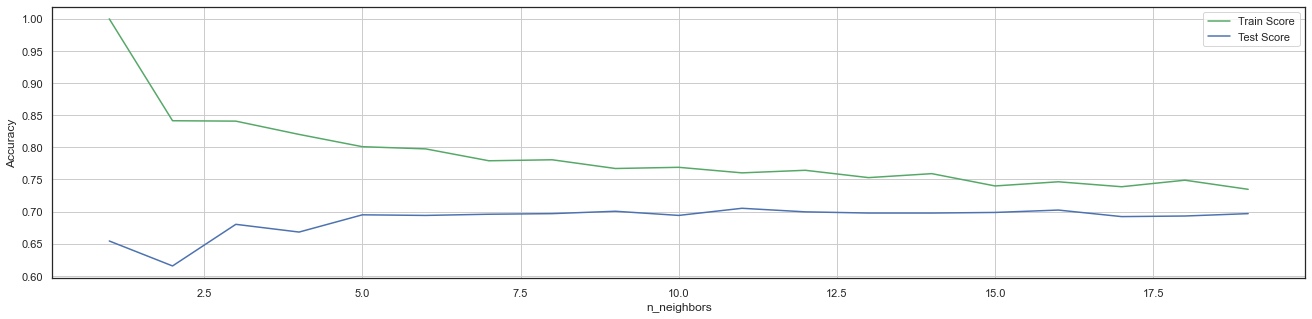

In [54]:
x_axis = range(1,20)
plt.subplots(figsize = (20,5))
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
knn2 = KNeighborsClassifier()
ki = np.arange(20)+1
param_knn2= [{'n_neighbors':ki}]
k_clfr = GridSearchCV(knn2, param_knn2, cv=5)
k_clfr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}])

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [58]:
print("The Best parameters: {}".format(k_clfr.best_params_))
print("The Best Score: {}".format(k_clfr.best_score_))

The Best parameters: {'n_neighbors': 11}
The Best Score: 0.7078582434514638


In [59]:
knn18 = KNeighborsClassifier(18)
knn18.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=18)

In [60]:
knn18_predict1 = knn18.predict(X_test)

In [61]:
print(classification_report(y_test, knn18_predict1))

              precision    recall  f1-score   support

           0       0.61      0.35      0.44       378
           1       0.71      0.88      0.79       704

    accuracy                           0.69      1082
   macro avg       0.66      0.61      0.61      1082
weighted avg       0.68      0.69      0.67      1082



### 6.3 Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []

for c in c_range:
    log_l1 = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', max_iter = 500)
    log_l2 = LogisticRegression(penalty = 'l2', C = c, solver = 'lbfgs', max_iter = 500)
    log_l1.fit(X_train, y_train)
    log_l2.fit(X_train, y_train)
    train_score_l1.append(log_l1.score(X_train, y_train))
    train_score_l2.append(log_l2.score(X_train, y_train))
    test_score_l1.append(log_l1.score(X_test, y_test))
    test_score_l2.append(log_l2.score(X_test, y_test))

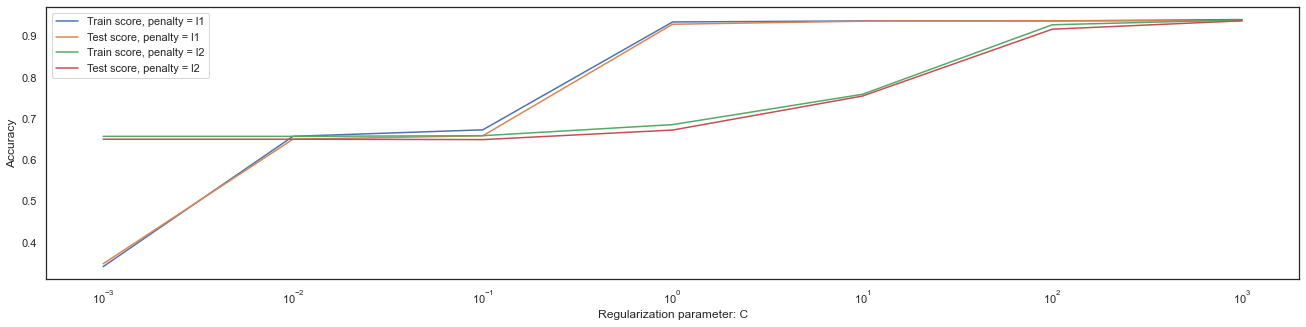

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize = (20,5))
plt.plot(c_range, train_score_l1, label = 'Train score, penalty = l1')
plt.plot(c_range, test_score_l1, label = 'Test score, penalty = l1')
plt.plot(c_range, train_score_l2, label = 'Train score, penalty = l2')
plt.plot(c_range, test_score_l2, label = 'Test score, penalty = l2')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Accuracy')
plt.xscale('log')

Best parameters are c=1,penality=l1;

In [65]:
LR1 = LogisticRegression(penalty = 'l1', C= 1,solver = 'liblinear', max_iter = 500)
LR1.fit(X_train,y_train)
print('Trainig set Accuracy (Logistic Regression) {:.4f}'.format(LR1.score(X_train, y_train)))
print('Test set Accuracy (Logistic Regression): {:.4f}'.format(LR1.score(X_test, y_test)))


Trainig set Accuracy (Logistic Regression) 0.9344
Test set Accuracy (Logistic Regression): 0.9288


In [66]:
logist_predict1 = LR1.predict(X_test)
print(classification_report(y_test, logist_predict1))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       378
           1       0.98      0.91      0.94       704

    accuracy                           0.93      1082
   macro avg       0.92      0.94      0.92      1082
weighted avg       0.94      0.93      0.93      1082



### 6.4 Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC

In [68]:
dtree_clfr = DecisionTreeClassifier()
parm = {'max_depth': [5, 10, 20, 50, 100]}

In [69]:
#gridsearch 
gs_dt = GridSearchCV(dtree_clfr, parm, cv = 5, return_train_score=True)
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 10, 20, 50, 100]},
             return_train_score=True)

In [70]:
print("The Best parameters are: {}".format(gs_dt.best_params_))
print("The Best Score is : {}".format(gs_dt.best_score_))

The Best parameters are: {'max_depth': 50}
The Best Score is : 0.9445300462249616


In [71]:
dtree_c = DecisionTreeClassifier(max_depth = 10)
dtree_c.fit(X_train,y_train)
dtree_c_pred = dtree_c.predict(X_test)

In [72]:
print("Accuracy on training set: {:.3f}".format(dtree_c.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dtree_c.score(X_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.937


In [73]:
print(classification_report(y_test,dtree_c_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       378
           1       0.96      0.94      0.95       704

    accuracy                           0.94      1082
   macro avg       0.93      0.93      0.93      1082
weighted avg       0.94      0.94      0.94      1082



### 6.5 Linear SVC

In [74]:
#Grid Search
parm = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gs_svm = GridSearchCV(LinearSVC(), parm, return_train_score=True,cv=5)
gs_svm.fit(X_train,y_train)
print(gs_svm.best_params_)

{'C': 100}


In [75]:
svm = LinearSVC(C=1000)

In [76]:
svm.fit(X_train,y_train)
svm_pre2 = svm.predict(X_test)

In [77]:
print(classification_report(y_test,svm_pre2))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       378
           1       1.00      0.89      0.94       704

    accuracy                           0.93      1082
   macro avg       0.92      0.95      0.93      1082
weighted avg       0.94      0.93      0.93      1082



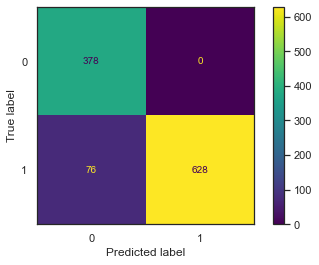

In [78]:
plot_confusion_matrix(svm, X_test, y_test)
plt.show()

### 6.6 Kernel SVC

In [79]:
Kernel_SVC1 = SVC(max_iter=10000)
Kernel_SVC1_parms = {'C':[0.001, 0.01, 0.1, 1, 10],'gamma':[1,0.1,0.001], 'kernel':['rbf','linear','poly']}

In [80]:
Kernel_SVC1_clfr = GridSearchCV(Kernel_SVC1, Kernel_SVC1_parms,cv=5)
Kernel_SVC1_clfr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [1, 0.1, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']})

In [81]:
print(Kernel_SVC1_clfr.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [82]:
kernel_svc_best = SVC(C= 10, gamma= 1, kernel= 'rbf')
kernel_svc_best.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [83]:
svm_best_pre = kernel_svc_best.predict(X_test)

In [84]:
print(classification_report(y_test,svm_best_pre))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       378
           1       0.87      0.88      0.88       704

    accuracy                           0.84      1082
   macro avg       0.82      0.82      0.82      1082
weighted avg       0.84      0.84      0.84      1082



### 6.7 Gradient Boosting Classifier

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.916
Accuracy on test set: 0.888


In [86]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.926
Accuracy on test set: 0.891


In [87]:
gbrt_pre = gbrt.predict(X_test)
print(classification_report(y_test,gbrt_pre))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       378
           1       0.90      0.94      0.92       704

    accuracy                           0.89      1082
   macro avg       0.89      0.87      0.88      1082
weighted avg       0.89      0.89      0.89      1082



## 7. Feature Importance

([<matplotlib.axis.YTick at 0x141897a90>,
 [Text(0, 0, 'min'),
  Text(0, 1, 'max'),
  Text(0, 2, 'mean'),
  Text(0, 3, 'categ_0'),
  Text(0, 4, 'categ_1'),
  Text(0, 5, 'categ_2'),
  Text(0, 6, 'categ_3'),
  Text(0, 7, 'categ_4')])

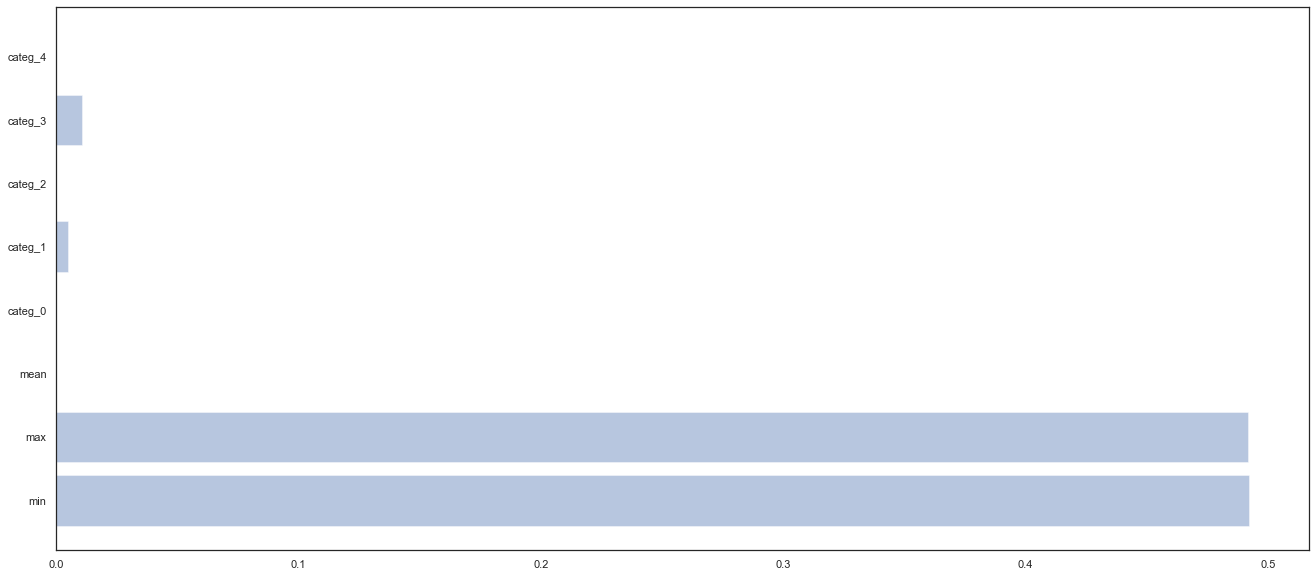

In [88]:
%matplotlib inline

plt.subplots(figsize = (20,10))
y_list = gbrt.feature_importances_
y_pos = np.arange(len(y_list))
features = X.columns
plt.barh(y_pos, y_list, align='center', alpha=0.4)
plt.yticks(y_pos, features)

It can be observed that only the max and min amount spent by the customer per transaction is an important feature for classifying them as repeat vs non-repeat buyer.

## 8. Principal Component Analysis

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_

array([0.35918048, 0.24453627, 0.18306629, 0.17523919])

In [90]:
sum(pca.explained_variance_ratio_)

0.9620222343238822

In [91]:
gbrt_pca = GradientBoostingClassifier(random_state=0)
gbrt_pca.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt_pca.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt_pca.score(X_test_pca, y_test)))


Accuracy on training set: 0.756
Accuracy on test set: 0.674


## 9. Best Model

Linear SVC with C = 100 is the best performing classifier with 0.93 accuracy score on the test dataset and 0.94 accuracy score on the train dataset.

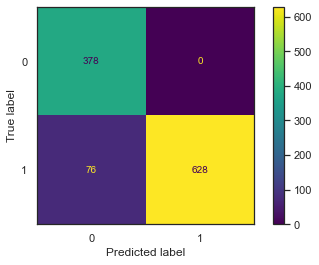

In [92]:
plot_confusion_matrix(svm, X_test, y_test)
plt.show()

## 10. Recommendation

This pipeline can be used to engineer features based on the shopping behavior of users which can then be leveraged to build classication model for the incentivizing repeat buyers.
Following features were engineered during the process
- max: Maximum amount spent per transcation by a customer
- min: Minimum amount spent per transaction by a customer
- mean: Average amount spent per transaction by a customer
- categ_N with 𝑁∈[0:4] : percentage spent in product category with index 𝑁 
- count: Number of times customer made a purchase
- repeat_buyer: binary value whether the customer is a repeat buyer or not

Using these features, a classifier was built to classify customers into repeat buyer vs non-repeat buyer (`repeat_buyer`) as the target column.

This model can be used by a company for predicting whether a customer will be a repeat buyer or not and then incentivizing possibly non repeat-buyers to be more active on their website and buy more products using targeted marketing campaigns, specialized discounts etc. while also monitoring repeat buyers. 